In [254]:
from typing import TypedDict,Literal,Annotated,Dict,Any,Union
from pydantic import BaseModel,Field
from langchain_core.messages import AnyMessage
from langgraph.graph import StateGraph,START,END,add_messages
from langgraph.prebuilt import create_react_agent
from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI

In [255]:
class state(TypedDict):
    input_email:str
    email_classifer:str
    next:str
    email_info:list| None
    output_email_subject:str
    output_email_body:str

In [256]:
from dotenv import load_dotenv
load_dotenv()

True

In [257]:
llm=ChatGoogleGenerativeAI(
    model="gemini-2.5-pro",
    temperature=0.5

)

In [258]:
class email_classifer(BaseModel):
    email_type:Literal["type A","type B"]=Field(description="Classify the emails into type A,type B,type C")

In [259]:
llm_classifer=llm.with_structured_output(email_classifer)

In [260]:
def classifer(state:state):
    email_msg=state['input_email']
    prompt = f"""
            You are an expert email classifier for an e-commerce company. 
            Your task is to classify incoming emails into one of the following categories:

            - type A: Emails related to customer service topics, including:
                - Return/refund policies and processing
                - Product issues or complaints
                - Exchanges
                
                - Product availability or sizing questions
                - Account-related issues (login, password, profile)
                - General customer support inquiries

            - type B: Emails related to order lifecycle and delivery, including:
                - Order confirmation and status
                - All payment related quation
                - Tracking and shipping details
                - Estimated delivery time
                - Delayed or lost shipments
                - Billing, payments, or invoice inquiries
                - Cancelation or modification of orders
                - refund payment confirmation and status
                - Delivery instructions or issues (e.g., address not found)

            Instructions:
            - Carefully analyze the emails content and intent.
            - Do not assume or hallucinate information. Base classification only on the available content.
            - Return only the category label ("type A","type B") without explanation or extra text.

            Classify the following email: {email_msg}
            """
    response=llm_classifer.invoke(prompt)
    
    return {"email_classifer":response.email_type}


In [261]:
def router(state:state):
    email_type=state.get("email_classifer")
    if email_type=="type A":
        return {"next":"type A"}
    elif email_type=="type B":
        return {"next":"type B"}
  

In [262]:

class type_A(BaseModel):
    Subject:str
    body:str
    


In [263]:
type_A_llm=llm.with_structured_output(type_A)

In [264]:
def type_A_writer(state:state):
    email_info=state["email_info"]
    
    from langchain.vectorstores import Chroma,FAISS
    from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings

    from dotenv import  load_dotenv
    load_dotenv()

    embadding=GoogleGenerativeAIEmbeddings(
        model="models/embedding-001"
    )
    DB_FAISS_PATH = 'vectorstore/db_faiss'

    db_loaded = FAISS.load_local(DB_FAISS_PATH, embadding, allow_dangerous_deserialization=True)
    retriever = db_loaded.as_retriever(search_type="similarity", search_kwargs={"k": 10})

    query = state["input_email"]
    results = retriever.invoke(query)

    page_contents = [doc.page_content for doc in results]


    prompt=f"""
        You are an AI email assistant representing Click&Cart, responding on behalf of Swapnil Patil, Manager at Click&Cart.

        Generate professional email replies based on provided context and user queries. Each response must be concise, helpful, and maintain brand consistency.

        - Context: {page_contents} - Background information and relevant details
        - user email info :{email_info}

        Output Requirements

        Email Structure
        1. Professional Greeting
        - Use appropriate salutation (Dear [Name], Hello [Name], etc.)
        - Default to "Dear Customer" if name is not available

        2. Concise Body
        - Maximum 3-4 sentences
        - Address the customer's specific concern directly
        - Reference relevant information from the provided context
        - Maintain a helpful and professional tone

        3. Professional Closing
        - Use standard business closings (Best regards, Sincerely, etc.)
        - Include signature block

        Mandatory Elements
        - Company Representation: All emails sent on behalf of Click&Cart
        - Sender Identity: Swapnil Patil, Manager at Click&Cart
        - Standard Footer: Include this text exactly as written at the end of every email:
        
        If your problem is not solved and you are still facing issues, contact us.
        Fill this form: https://forms.gle/MYmJbdixXDQQ2iqx5
        

        Example Output Structure

        Dear [Customer Name],

        [2-3 sentences addressing their specific concern based on context]

        [1 sentence with next steps or resolution]

        Best regards,
        Swapnil Patil
        Manager, Click&Cart

        If your problem is not solved and you are still facing issues, contact us.
        Fill this form: https://forms.gle/MYmJbdixXDQQ2iqx5
         """
    response=type_A_llm.invoke(prompt)
    return {"output_email_subject":response.Subject,"output_email_body":response.body}



In [265]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///ecommerce_workspace.db")

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM customers LIMIT 5;")}')

Dialect: sqlite
Available tables: ['customers', 'order_items', 'orders', 'payments', 'products', 'shipments', 'suppliers']
Sample output: [(1, 'John Smith', 'john.smith@email.com', 'New York'), (2, 'Sarah Johnson', 'sarah.j@email.com', 'Los Angeles'), (3, 'Mike Wilson', 'mike.wilson@email.com', 'Chicago'), (4, 'Emma Davis', 'emma.davis@email.com', 'Houston'), (5, 'David Brown', 'david.brown@email.com', 'Phoenix')]


In [266]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [267]:

system_prompt = """

 You are an AI email assistant representing Click&Cart, responding on behalf of Swapnil Patil, Manager at Click&Cart.
Given the following customer email , determine if you need to query the database to fetch relevent data use
use the SQLDatabaseToolkit to fetch the relevant data

If no DB call is needed, just write the response.

if you need to query the database to fetch the relevant data and 
email has not given any relevant data to query data based  write response to get that relevent data (like user id, product id , transaction id)

Finally, write a polite, clear, natural language email reply with the information retrieved.

Mandatory Elements
        - Company Representation: All emails sent on behalf of Click&Cart
        - Sender Identity: Swapnil Patil, Manager at Click&Cart
        - Standard Footer: Include this text exactly as written at the end of every email:
            If your problem is not solved and you are still facing issues, contact us.
            Fill this form: https://forms.gle/MYmJbdixXDQQ2iqx5



Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
"""



In [268]:
class type_B_val(BaseModel):
    subject:str
    body:str

In [269]:
def type_B_writer(state:state):
    email_txt=state["input_email"]

    prompt_template = system_prompt
    system_message = prompt_template.format(dialect="SQLite", top_k=5)

    # Create agent
    agent_executor = create_react_agent(
        llm, toolkit.get_tools(), state_modifier=system_message
    )


    events = agent_executor.stream(
        {"messages": [("user", email_txt)]},
        stream_mode="values",
    )

    final_response = None
    for event in events:
        event["messages"][-1].pretty_print()
        final_response = event["messages"][-1].content

    # Apply structured output parsing to the final response
    structured_llm = llm.with_structured_output(type_B_val)
    structured_result = structured_llm.invoke(f"Extract the email subject and body from this response: {final_response}")
  
    return {"output_email_subject":structured_result.subject,"output_email_body":structured_result.body}
    

In [270]:
import email_management
from email.header import decode_header
import imaplib
import email
import smtplib
import ssl
from email.message import EmailMessage
import os
import re
from datetime import datetime
import time

In [271]:
def get_email(state:state):

    """Fetch unread emails and return their content"""
    email_address = 'mailreplyer5090@gmail.com'
    email_password = 'wfkj ohob ezhi arux'
    unread_emails = []
   
    
    imap = imaplib.IMAP4_SSL("imap.gmail.com")
    imap.login(email_address, email_password)
    imap.select("INBOX")
    _, message_numbers = imap.search(None, "UNSEEN")
    
    num_messages = len(message_numbers[0].split())
    
    
    for num in message_numbers[0].split():
        _, msg = imap.fetch(num, "(RFC822)")
        email_body = msg[0][1]
        email_message = email.message_from_bytes(email_body)
        
        subject = decode_header(email_message["Subject"])[0][0]
        if isinstance(subject, bytes):
            subject = subject.decode()
            
        from_ = decode_header(email_message.get("From"))[0][0]
        if isinstance(from_, bytes):
            from_ = from_.decode()
        
        # Extract email address
        email_pattern = r'<(.+?)>'
        email_match = re.search(email_pattern, from_)
        sender_email = email_match.group(1) if email_match else from_
        
        # Get email body
        body = ""
        if email_message.is_multipart():
            for part in email_message.walk():
                if part.get_content_type() == "text/plain":
                    body = part.get_payload(decode=True).decode()
                    break
        else:
            body = email_message.get_payload(decode=True).decode()
        
        unread_emails.append({
            'subject': subject,
            'from': from_,
            'sender_email': sender_email,
            'sender_name': email_management.get_sender_name(from_),
            'body': body
        })
        
    
    imap.close()
    imap.logout()
    return {"input_email":unread_emails[0]["body"],"email_info":unread_emails}
    
   

In [272]:
 
def send_email(state:state):

    receiver=state["email_info"][0]["sender_email"]
    subject=state["output_email_subject"]
    body=state["output_email_body"]
  
    EMAIL_SENDER = 'mailreplyer5090@gmail.com'
    EMAIL_PASSWORD = 'App Password'
    em = EmailMessage()
    em['From'] = EMAIL_SENDER
    em['To'] = receiver
    em['Subject'] = subject
    em.set_content(body)
    
    context = ssl.create_default_context()
    with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=context) as smtp:
        smtp.login(EMAIL_SENDER, EMAIL_PASSWORD)
        smtp.sendmail(EMAIL_SENDER, receiver, em.as_string())
        
      


In [273]:

def mark_emails_as_unread(state:state):
    """
    Mark multiple emails as unread
    
    Args:
        email_list (list): List of dictionaries containing email identifiers
                          Each dict should have 'subject' and/or 'sender_email' keys
    
    Returns:
        int: Number of emails successfully marked as unread
    """
    email_list=state["email_info"][0]
    email_address = 'mailreplyer5090@gmail.com'
    email_password = 'wfkj ohob ezhi arux'
    success_count = 0
    
    
    imap = imaplib.IMAP4_SSL("imap.gmail.com")
    imap.login(email_address, email_password)
    imap.select("INBOX")
        
    for email_info in email_list:
        try:
            subject = email_info.get('subject')
            sender = email_info.get('sender_email')
            
            # Build search criteria
            search_criteria = "ALL"
            if sender and subject:
                search_criteria = f'(FROM "{sender}" SUBJECT "{subject}")'
            elif sender:
                search_criteria = f'FROM "{sender}"'
            elif subject:
                search_criteria = f'SUBJECT "{subject}"'
            
            _, message_numbers = imap.search(None, search_criteria)
            
            if message_numbers[0]:
                # Mark the most recent matching email as unread
                message_num = message_numbers[0].split()[-1]
                imap.store(message_num, '-FLAGS', '\\Seen')
                success_count += 1
              
            
        except Exception as e:
            
            continue
    
    imap.close()
    imap.logout()
       


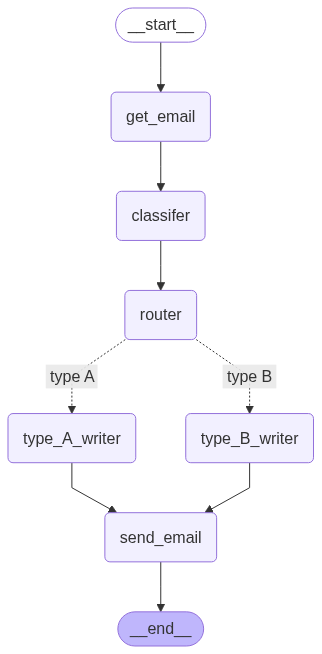

In [274]:
graph=StateGraph(state)

graph.add_node("get_email",get_email)
graph.add_node("classifer",classifer)
graph.add_node("router",router)
graph.add_node("type_A_writer",type_A_writer)
graph.add_node("type_B_writer",type_B_writer)
graph.add_node("send_email",send_email)


graph.add_edge(START,"get_email")
graph.add_edge("get_email","classifer")
graph.add_edge("classifer","router")
graph.add_conditional_edges("router",
                            lambda state:state.get("next"),
                            {"type A":"type_A_writer",
                             "type B":"type_B_writer"
                             })
graph.add_edge("type_A_writer","send_email")
graph.add_edge("send_email",END)

graph.add_edge("type_B_writer","send_email")


graph_compiled=graph.compile()


from IPython.display import Image, display


# Display the graph visualization
display(Image(graph_compiled.get_graph().draw_mermaid_png()))


In [275]:
initial_state = {
        "input_email": None,
        "email_classifer": None,
        "next": None,
        "email_info": [],
        "output_email_subject":None,
        "output_email_body":None

    }  # or whatever your state structure requires
result = graph_compiled.invoke(initial_state)

# Fix 2: print_prity should be print_pretty or just use pprint
from pprint import pprint

print("=== GRAPH EXECUTION RESULT ===")
pprint(result)

================================ Human Message =================================

dear sir/ma'am ,

I made a payment  yesterday using UPI, but I havent received any payment
confirmation from your side. Can you please confirm if the payment has been
received?
order id 7

Thanks,
Megha

================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (c6995ae4-7ba3-4cde-9fdb-6a2821bc6f01)
 Call ID: c6995ae4-7ba3-4cde-9fdb-6a2821bc6f01
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

customers, order_items, orders, payments, products, shipments, suppliers
================================== Ai Message ==================================

Megha is asking for a payment confirmation for order id 7. I should query the `payments` table to check the status of the payment for this order. First, I will look at the schema of the `orders` and `payments` tables to understa